# Проект: исследование метрик и эффектов с помощью проведения A/B тестирования

---



In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from numpy import random
from scipy import stats
from scipy.stats import t, norm
from sklearn.model_selection import train_test_split
from scipy.stats import normaltest
from scipy.stats import ttest_ind

Получение данных через clickhouse

In [119]:
# !pip install clickhouse_driver

In [120]:
# !pip install clickhouse_connect

In [121]:
# import pandas as pd
# from clickhouse_driver import Client
# import clickhouse_connect

# client = clickhouse_connect.get_client(host='127.0.0.0',
#                                       port=8123,
#                                       user='default',
#                                       password='')

# QUERY = '''
# select day, user_id, group_id, exp_metric_id, numerator, denominator
# from exp_metrics.exp_1
# '''

# result = client.execute(QUERY)

# data = pd.Series(result,
#                         index=['day', 'user_id', 'group_id', 'exp_metric_id', 'numerator', 'denominator']
#                         )

Получение данных через файл.csv

In [122]:
data = pd.read_csv('data-2.csv')

In [123]:
data.head()

,day,user_id,group_id,exp_metric_id,numerator,denominator
0,2023-12-18,933811702715356,1,0,0.0,0.0
1,2023-12-18,933811702715356,1,1,0.0,0.0
2,2023-12-18,933811702715356,1,2,0.0,0.0
3,2023-12-18,933811702715356,1,3,0.0,3.0
4,2023-12-18,933811702715356,1,4,2.0,0.0


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'group_id'}>],
       [<Axes: title={'center': 'exp_metric_id'}>,
        <Axes: title={'center': 'numerator'}>],
       [<Axes: title={'center': 'denominator'}>, <Axes: >]], dtype=object)

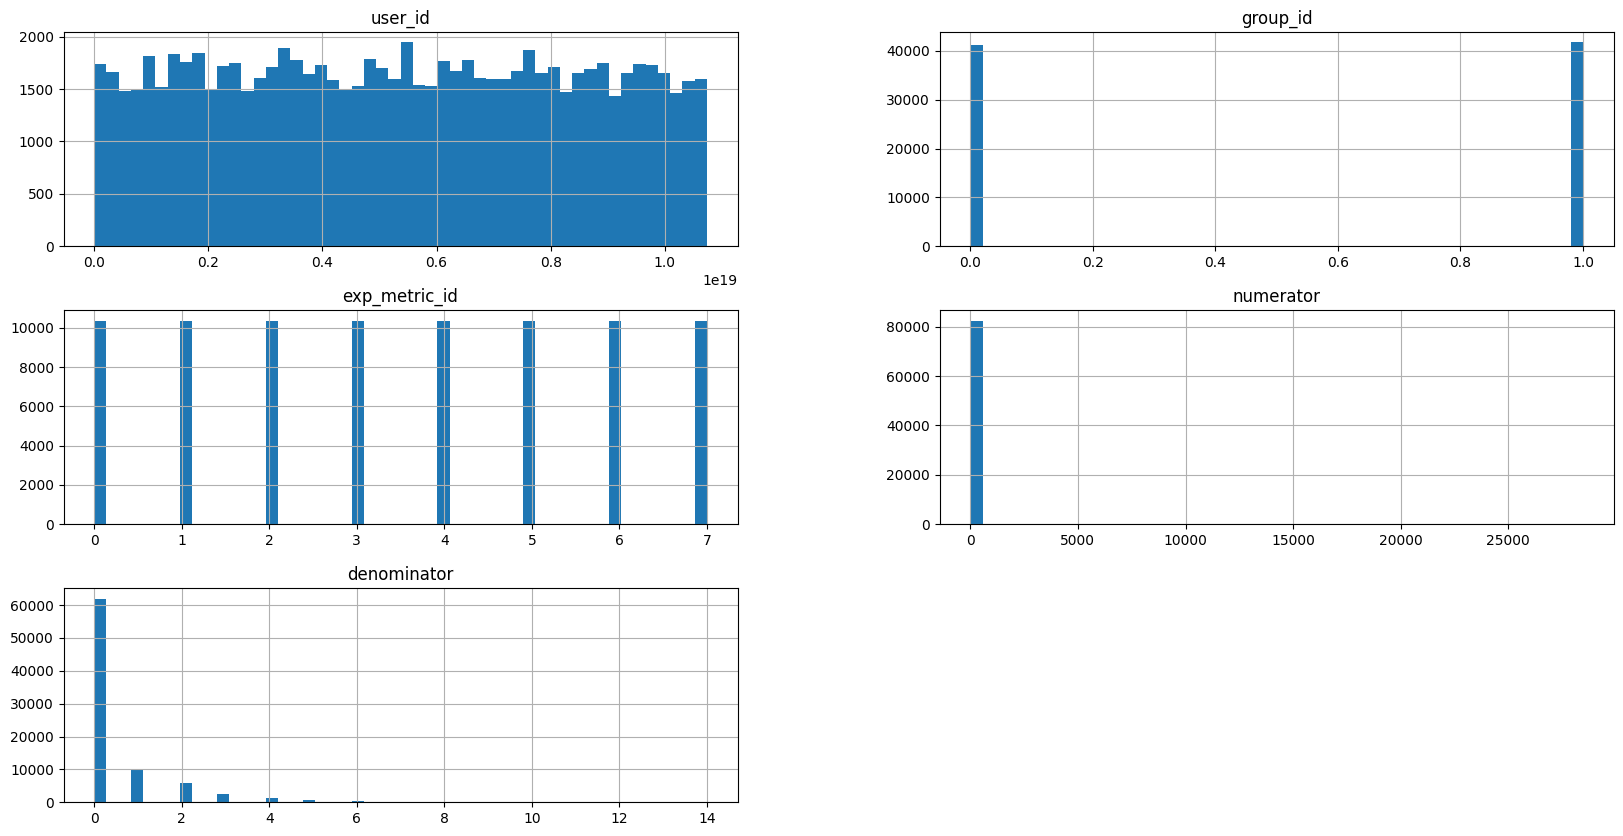

In [124]:
data.hist(bins=50, figsize=(20, 10))

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82952 entries, 0 to 82951
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            82952 non-null  object 
 1   user_id        82952 non-null  uint64 
 2   group_id       82952 non-null  int64  
 3   exp_metric_id  82952 non-null  int64  
 4   numerator      82952 non-null  float64
 5   denominator    82952 non-null  float64
dtypes: float64(2), int64(2), object(1), uint64(1)
memory usage: 3.8+ MB


In [126]:
data.describe()

,user_id,group_id,exp_metric_id,numerator,denominator
count,8.295200e+04,82952.000000,82952.000000,82952.000000,82952.000000
mean,5.342253e+18,0.503038,3.500000,20.709412,0.508125
std,3.084633e+18,0.499994,2.291302,392.024914,1.127182
min,9.338117e+14,0.000000,0.000000,0.000000,0.000000
25%,2.660047e+18,0.000000,1.750000,0.000000,0.000000
50%,5.349013e+18,1.000000,3.500000,0.000000,0.000000
75%,7.990169e+18,1.000000,5.250000,1.000000,1.000000
max,1.073620e+19,1.000000,7.000000,28468.358430,14.000000


In [127]:
print(data['day'].max(), data['day'].min())

2023-12-18 2023-12-18


In [128]:
print('number of control group:', len(data[data['group_id'] == 0]), '\nnumber of test (experiment) group:', len(data[data['group_id'] == 1]))

number of control group: 41224 
number of test (experiment) group: 41728


In [129]:
# Разделение выборки на тестовую и контрольную
control_data, test_data = data[data['group_id'] == 0], data[data['group_id'] == 1]

In [130]:
control_data.head()

,day,user_id,group_id,exp_metric_id,numerator,denominator
8,2023-12-18,1109881702910509,0,0,0.0,0.0
9,2023-12-18,1109881702910509,0,1,0.0,0.0
10,2023-12-18,1109881702910509,0,2,0.0,0.0
11,2023-12-18,1109881702910509,0,3,0.0,2.0
12,2023-12-18,1109881702910509,0,4,2.0,0.0


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'group_id'}>],
       [<Axes: title={'center': 'exp_metric_id'}>,
        <Axes: title={'center': 'numerator'}>],
       [<Axes: title={'center': 'denominator'}>, <Axes: >]], dtype=object)

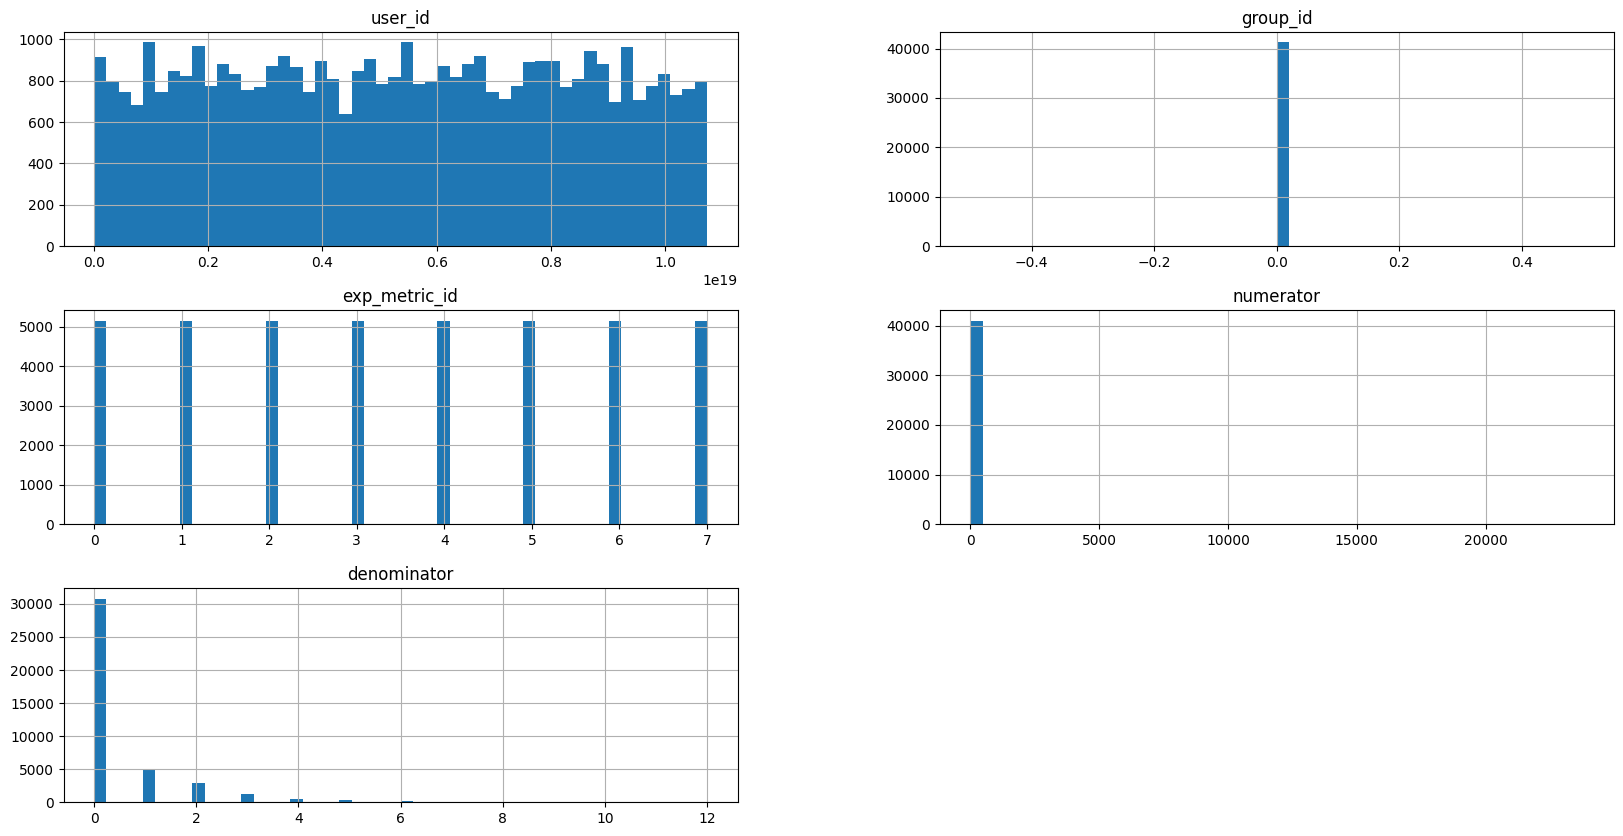

In [131]:
control_data.hist(bins=50, figsize=(20, 10))

In [132]:
control_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41224 entries, 8 to 82919
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            41224 non-null  object 
 1   user_id        41224 non-null  uint64 
 2   group_id       41224 non-null  int64  
 3   exp_metric_id  41224 non-null  int64  
 4   numerator      41224 non-null  float64
 5   denominator    41224 non-null  float64
dtypes: float64(2), int64(2), object(1), uint64(1)
memory usage: 2.2+ MB


In [133]:
test_data.head()

,day,user_id,group_id,exp_metric_id,numerator,denominator
0,2023-12-18,933811702715356,1,0,0.0,0.0
1,2023-12-18,933811702715356,1,1,0.0,0.0
2,2023-12-18,933811702715356,1,2,0.0,0.0
3,2023-12-18,933811702715356,1,3,0.0,3.0
4,2023-12-18,933811702715356,1,4,2.0,0.0


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'group_id'}>],
       [<Axes: title={'center': 'exp_metric_id'}>,
        <Axes: title={'center': 'numerator'}>],
       [<Axes: title={'center': 'denominator'}>, <Axes: >]], dtype=object)

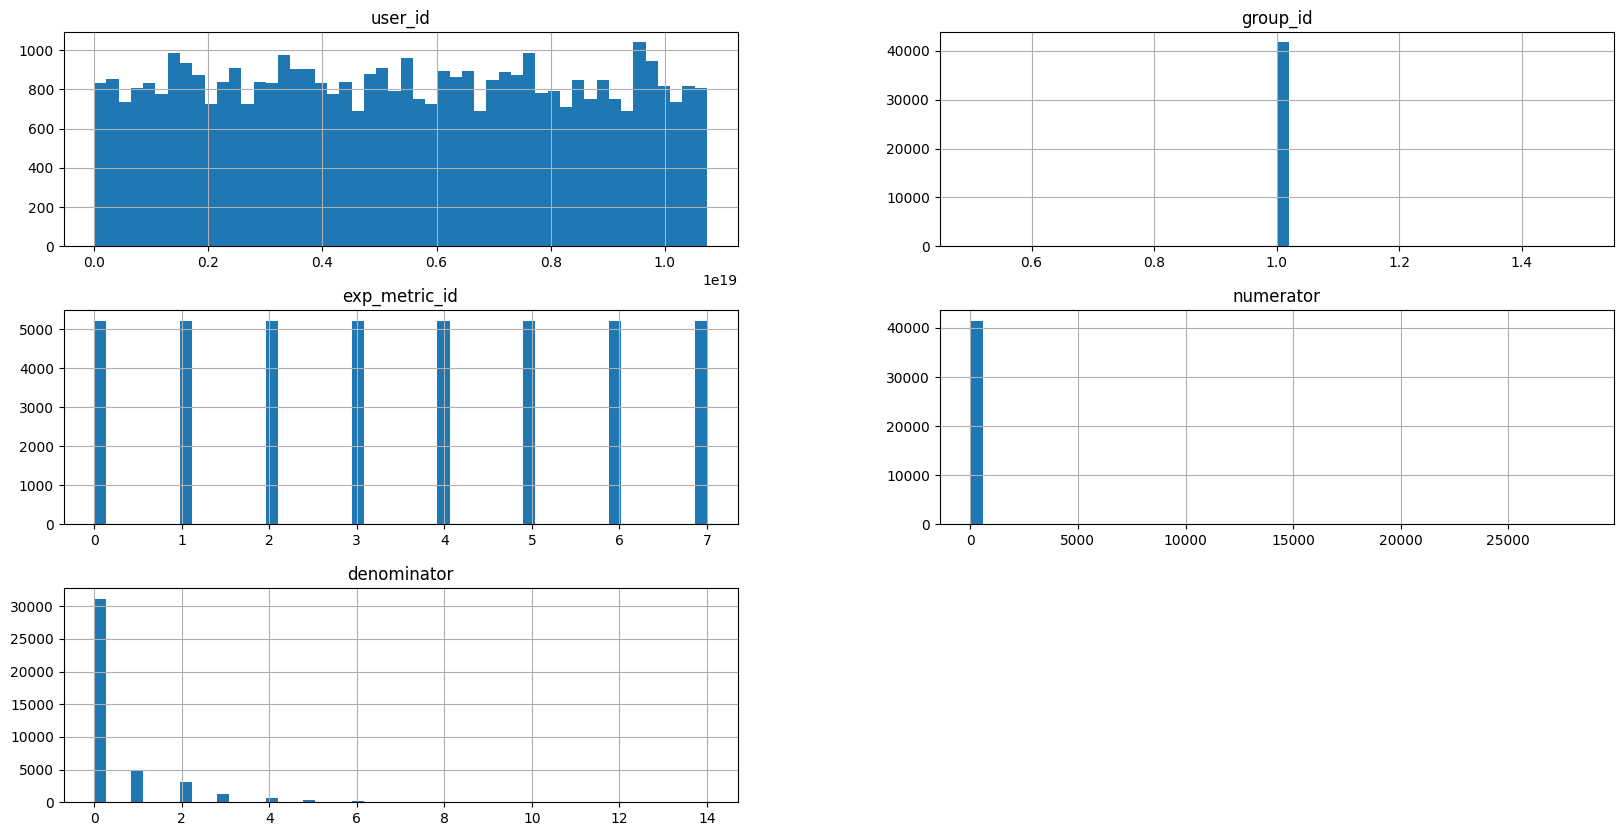

In [134]:
test_data.hist(bins=50, figsize=(20, 10))

In [135]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41728 entries, 0 to 82951
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            41728 non-null  object 
 1   user_id        41728 non-null  uint64 
 2   group_id       41728 non-null  int64  
 3   exp_metric_id  41728 non-null  int64  
 4   numerator      41728 non-null  float64
 5   denominator    41728 non-null  float64
dtypes: float64(2), int64(2), object(1), uint64(1)
memory usage: 2.2+ MB


### Распределения метрик для контрольной и тестовой выборки

In [136]:
# Функция для вывода гистограмм распределений метрик
def plot_double_histogram(num_metric, data1, data2, range=None, title1='Histogram 1', title2='Histogram 2', xlabel='Значение', ylabel='Частота'):
    plt.figure(figsize=(12, 6))

    if range == None:
        plt.hist(data1, bins=50, color='blue', alpha=0.7, label=title1)  # Гистограмма для данных 1
        plt.hist(data2, bins=50, color='green', alpha=0.7, label=title2)  # Гистограмма для данных 2
    else:
        plt.hist(data1, bins=50, range=range, color='blue', alpha=0.7, label=title1)  # Гистограмма для данных 1
        plt.hist(data2, bins=50, range=range, color='green', alpha=0.7, label=title2)  # Гистограмма для данных 2

    d = {
        0: 'сумма покупок',
        1: 'количество заказов',
        2: 'средний чек',
        3: 'количество сессий с покупками /  количество уникальных сессий',
        4: 'кол-во сессий',
        5: 'добавления в корзину',
        6: 'кол-во просмотров в карте товара',
        7: 'кол-во просмотров в карте товара за сессию'
        }

    plt.title(f'Распределение метрики {num_metric}: "{d[num_metric]}"')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [137]:
# Функция для расчёта метрик
def get_metric(num_metric, group_id, den=0):
    numenator = data[(data['exp_metric_id'] == num_metric) & (data['group_id'] == group_id)]['numerator']
    denominator = data[(data['exp_metric_id'] == num_metric) & (data['group_id'] == group_id)]['denominator']

    if den != 0:
        denominator = pd.Series([1 for i in denominator])

    result = numenator / denominator

    return result

Метрика 0:

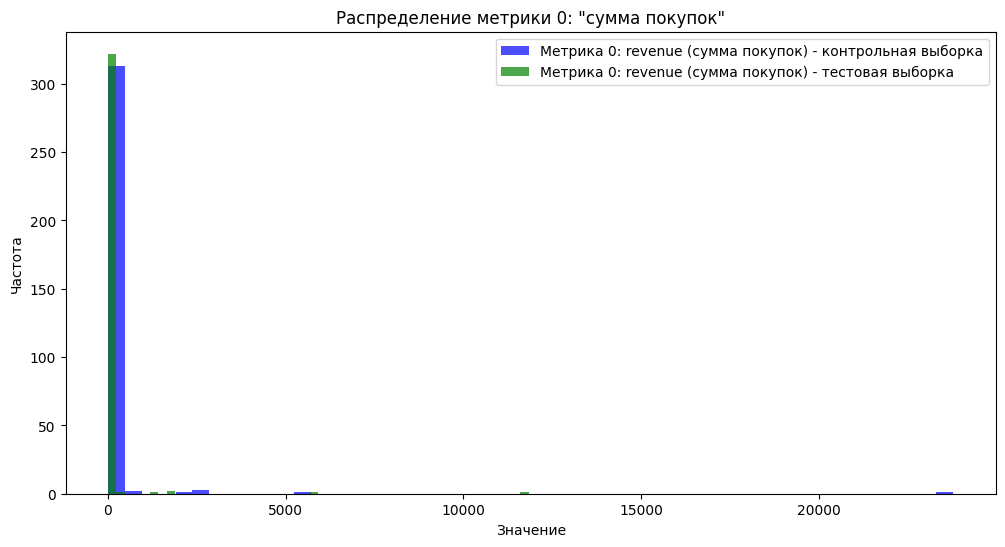

In [138]:
metric_0_control = get_metric(0, 0, 1)
metric_0_test = get_metric(0, 1, 1)

plot_double_histogram(0, metric_0_control,
                      metric_0_test,
                      range=None,
                      title1 = 'Метрика 0: revenue (сумма покупок) - контрольная выборка',
                      title2 = 'Метрика 0: revenue (сумма покупок) - тестовая выборка')

Метрика 1:

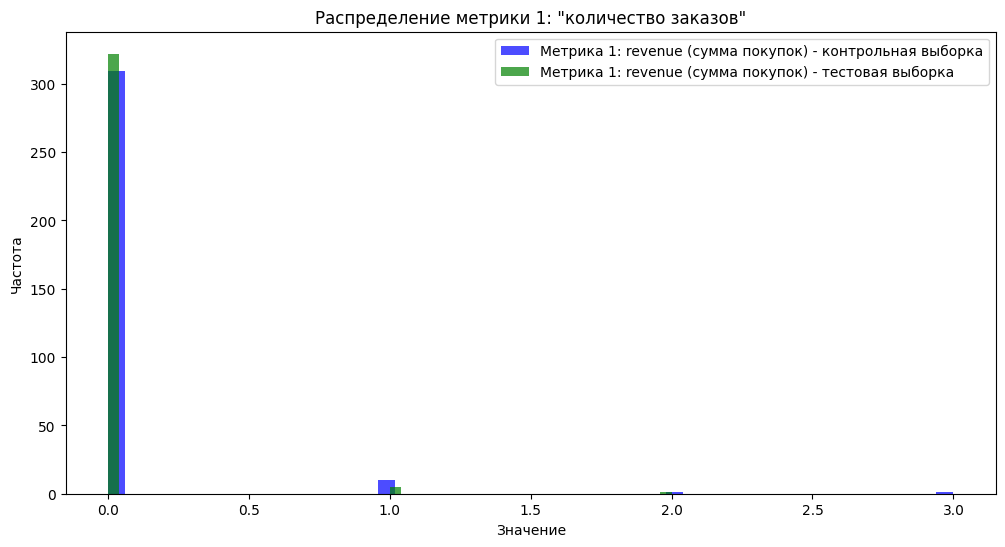

In [139]:
metric_1_control = get_metric(1, 0, 1)
metric_1_test = get_metric(1, 1, 1)

plot_double_histogram(1, metric_1_control,
                      metric_1_test,
                      title1 = 'Метрика 1: revenue (сумма покупок) - контрольная выборка',
                      title2 = 'Метрика 1: revenue (сумма покупок) - тестовая выборка')

Метрика 2:

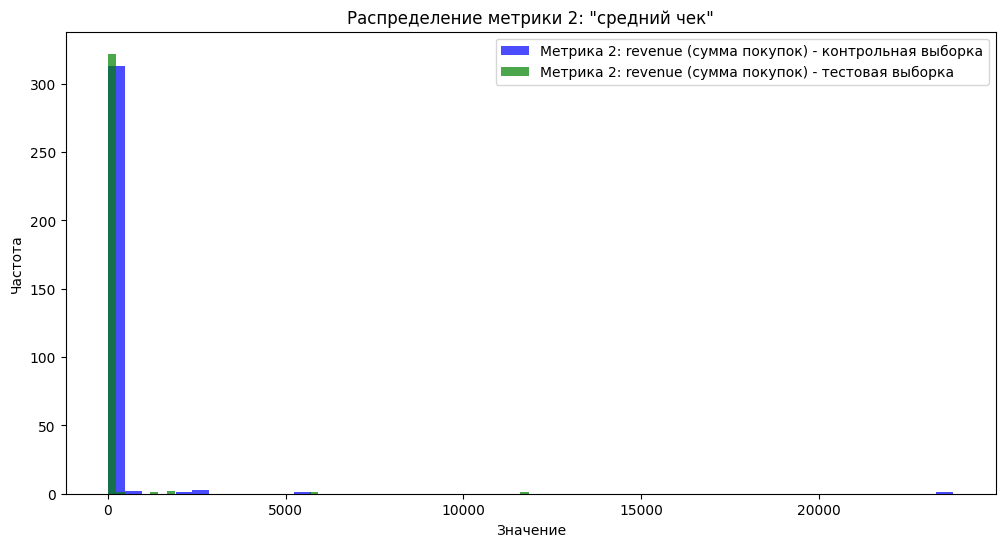

In [140]:
metric_2_control = get_metric(2, 0, 2)
metric_2_test = get_metric(2, 1, 2)

plot_double_histogram(2, metric_2_control,
                      metric_2_test,
                      title1 = 'Метрика 2: revenue (сумма покупок) - контрольная выборка',
                      title2 = 'Метрика 2: revenue (сумма покупок) - тестовая выборка')

Метрика 3:

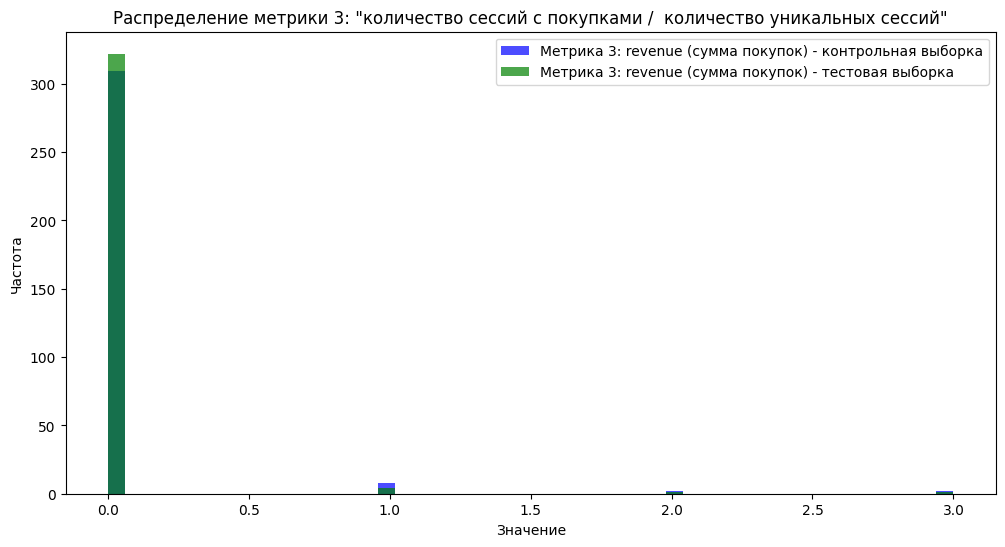

In [141]:
metric_3_control = get_metric(3, 0, 3)
metric_3_test = get_metric(3, 1, 3)

plot_double_histogram(3, metric_3_control,
                      metric_3_test,
                      title1 = 'Метрика 3: revenue (сумма покупок) - контрольная выборка',
                      title2 = 'Метрика 3: revenue (сумма покупок) - тестовая выборка')

Метрика 4:

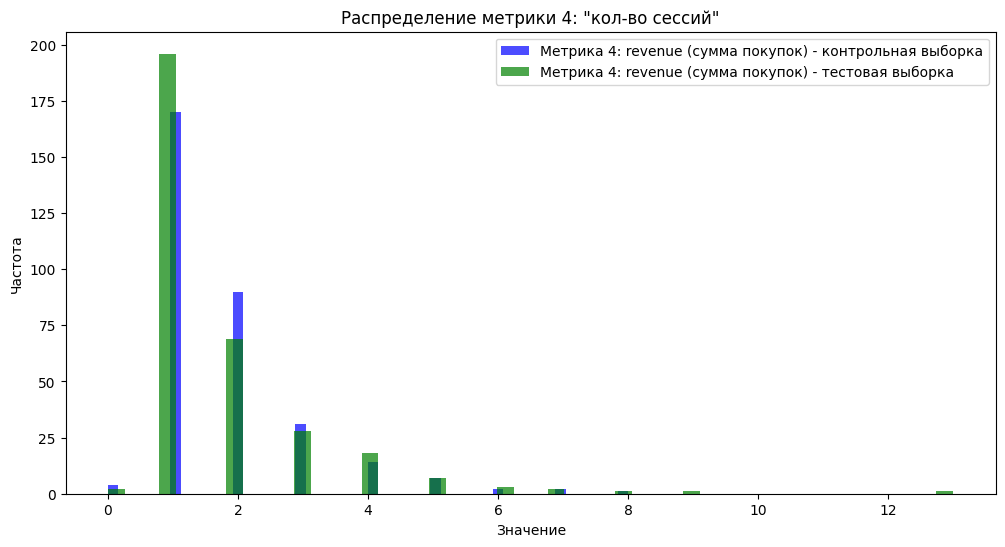

In [142]:
metric_4_control = get_metric(4, 0, 4)
metric_4_test = get_metric(4, 1, 4)

plot_double_histogram(4, metric_4_control,
                      metric_4_test,
                      title1 = 'Метрика 4: revenue (сумма покупок) - контрольная выборка',
                      title2 = 'Метрика 4: revenue (сумма покупок) - тестовая выборка')

Метрика 5:

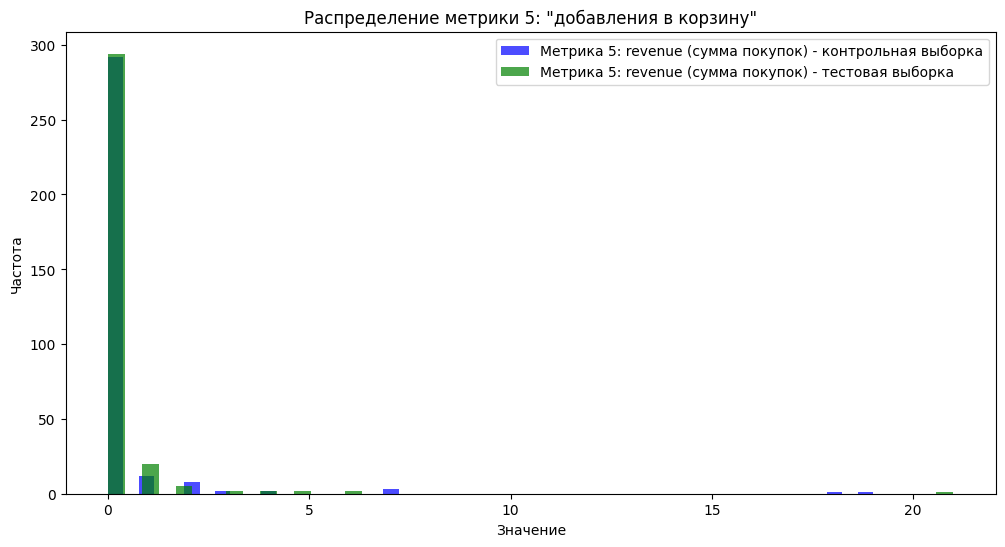

In [143]:
metric_5_control = get_metric(5, 0, 5)
metric_5_test = get_metric(5, 1, 5)

plot_double_histogram(5, metric_5_control,
                      metric_5_test,
                      title1 = 'Метрика 5: revenue (сумма покупок) - контрольная выборка',
                      title2 = 'Метрика 5: revenue (сумма покупок) - тестовая выборка')

Метрика 6:

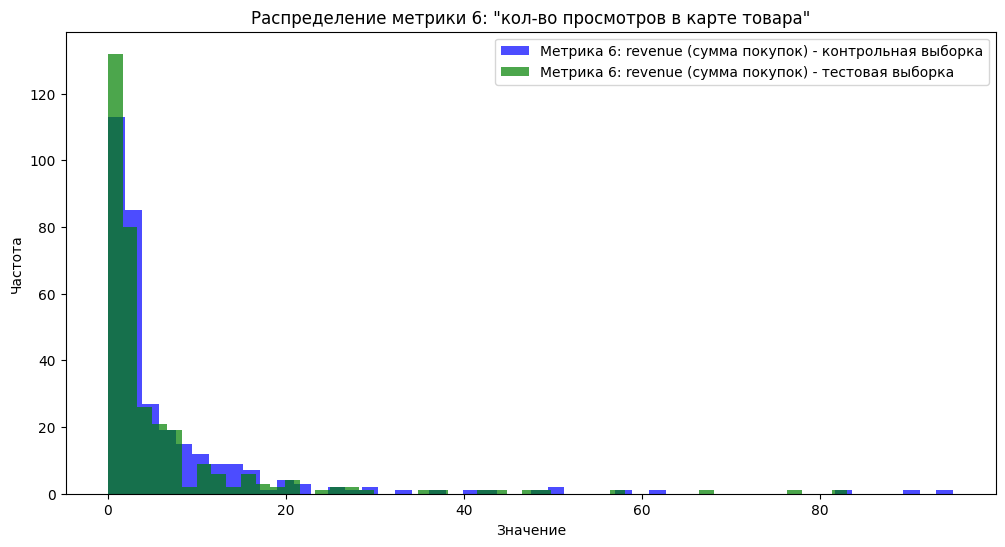

In [144]:
metric_6_control = get_metric(6, 0, 6)
metric_6_test = get_metric(6, 1, 6)

plot_double_histogram(6, metric_6_control,
                      metric_6_test,
                      title1 = 'Метрика 6: revenue (сумма покупок) - контрольная выборка',
                      title2 = 'Метрика 6: revenue (сумма покупок) - тестовая выборка')

Метрика 7:

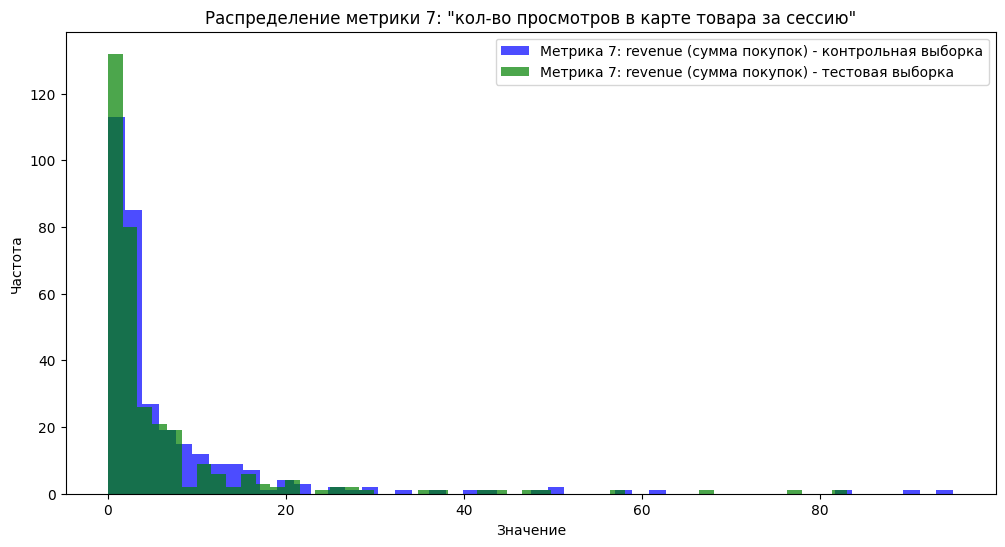

In [145]:
metric_7_control = get_metric(7, 0, 7)
metric_7_test = get_metric(7, 1, 7)

plot_double_histogram(7, metric_7_control,
                      metric_7_test,
                      title1 = 'Метрика 7: revenue (сумма покупок) - контрольная выборка',
                      title2 = 'Метрика 7: revenue (сумма покупок) - тестовая выборка')

## 1. Формулирование гипотез


- Нулевая гипотеза $H_0$: $μ_{control} = μ_{test}$, среднее значение метрики в контрольной и тестовой группах исследования - совпадают.
- Альтернативная гипотеза $H_1$: $μ_{control} \not= μ_{test}$, среднее значение метрики в контрольной и тестовой группах исследования - отличаются.

  **Всего имеется 8 метрик. Для каждой метрики нужно проверить описанную гипотезу.**

## 2. Выбор статистического метода

В работе будут использованы бутстрап с дельта-методом.

Причина: тест Стьюдента не работает для метрик отношения из-за зависимых данных. Следовательно происходит неправильная оценка дисперсии. Для оценки дисперсии зависимых данных недостаточно просто вычислить выборочную дисперсию.

Основная особенность применение бутстрепа для метрик отношения — данные необходимо семплировать по объектам, а не по наблюдениям. Если объект оказался в определённой группе, то и все его действия будут в этой группе.

## 3. Расчёт статистик

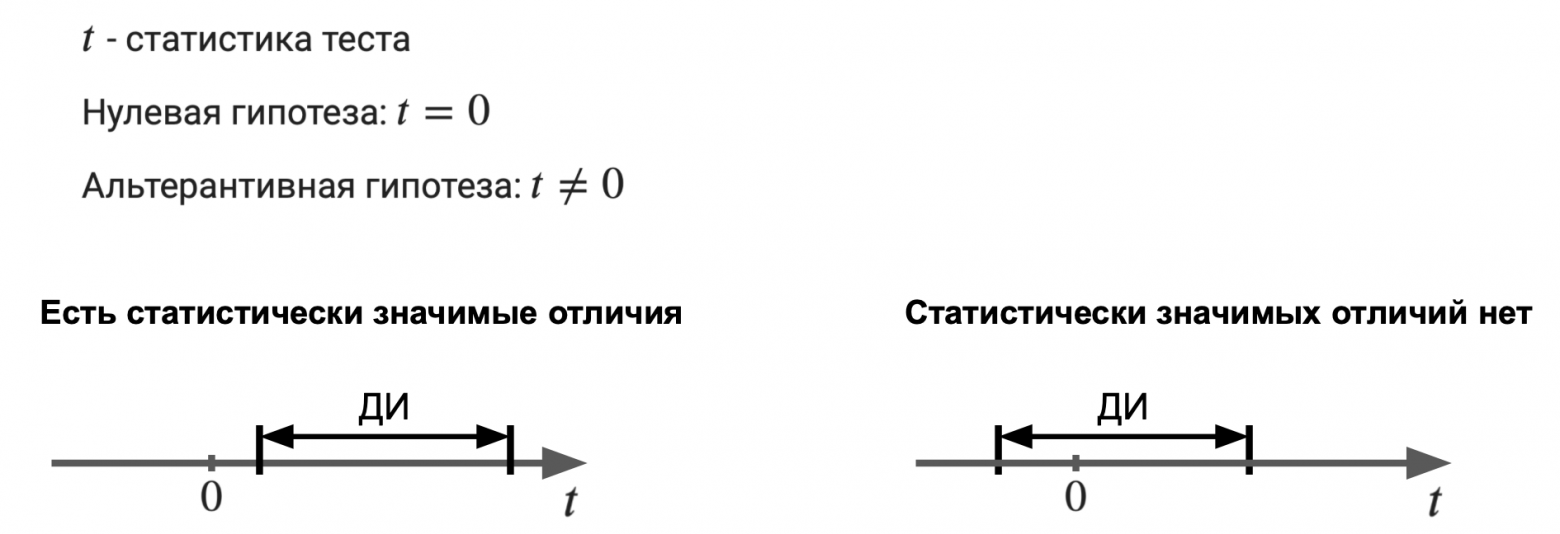

In [146]:
# Доверительные интервалы по бутстрепу
def get_percentile_ci(bootstrap_stats, alpha):
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

In [147]:
# Бутстреп
def check_bootstrap(control, test, n_iter, alpha):
    num_den_control = np.array([[sum(values), len(values)] for values in control])
    num_den_test = np.array([[sum(values), len(values)] for values in test])

    len_control = len(control)
    len_test = len(test)

    indexes_control = np.random.choice(np.arange(len_control), size=(n_iter, len_control), replace=True)
    indexes_test = np.random.choice(np.arange(len_test), size=(n_iter, len_test), replace=True)

    bootstrap_stats = []
    for idx_control, idx_test in zip(indexes_control, indexes_test):
        bootstrap_num_den_control = num_den_control[idx_control]
        bootstrap_num_den_test = num_den_test[idx_test]
        bootstrap_stat = (bootstrap_num_den_test[:, 0].sum() / bootstrap_num_den_test[:, 1].sum()) - \
                         (bootstrap_num_den_control[:, 0].sum() / bootstrap_num_den_control[:, 1].sum())
        bootstrap_stats.append(bootstrap_stat)

    ci = get_percentile_ci(bootstrap_stats, alpha)
    has_effect = 1 - (ci[0] < 0 < ci[1])

    return has_effect, ci

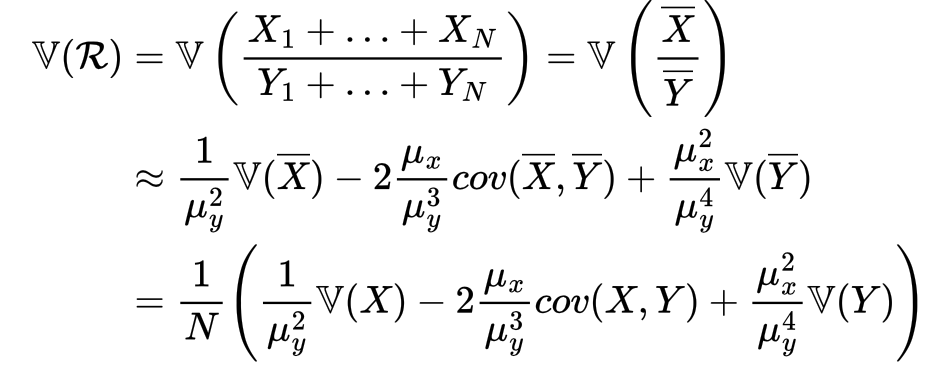

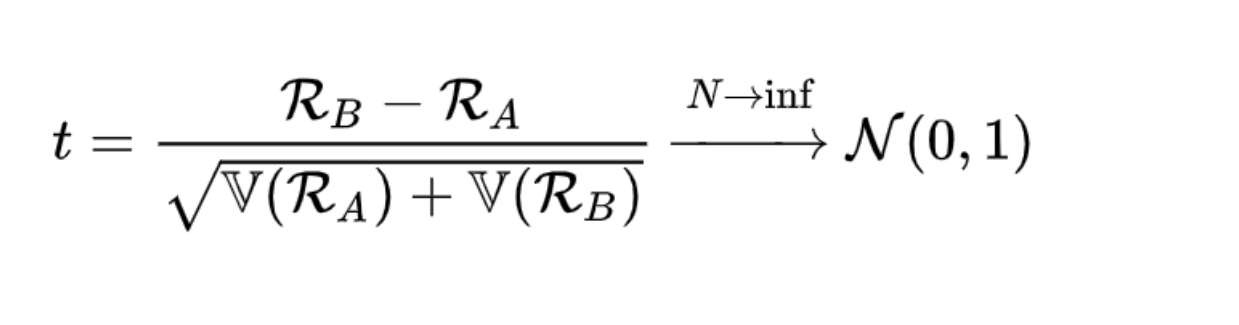

In [148]:
# Дельта-метод
def check_delta_method(control, test):
    n_user_control = len(control)
    n_user_test = len(test)

    array_num_control = np.array([np.sum(row) for row in control])
    array_den_control = np.array([len(row) for row in control])
    array_num_test = np.array([np.sum(row) for row in test])
    array_den_test = np.array([len(row) for row in test])

    mean_num_control, mean_den_control = np.mean(array_num_control), np.mean(array_den_control)
    mean_num_test, mean_den_test = np.mean(array_num_test), np.mean(array_den_test)

    var_num_control, var_den_control = np.var(array_num_control), np.var(array_den_control)
    var_num_test, var_den_test = np.var(array_num_test), np.var(array_den_test)

    cov_num_den_control = np.cov(array_num_control, array_den_control)[0, 1]
    cov_num_den_test = np.cov(array_num_test, array_den_test)[0, 1]

    pe_metric_control = np.sum(array_num_control) / np.sum(array_den_control)
    pe_metric_test = np.sum(array_num_test) / np.sum(array_den_test)

    var_metric_control = (var_num_control / mean_den_control ** 2 - 2 * (mean_num_control / mean_den_control ** 3) * cov_num_den_control +
                    (mean_num_control ** 2 / mean_den_control ** 4) * var_den_control) / n_user_control
    var_metric_test = (var_num_test / mean_den_test ** 2 - 2 * (mean_num_test / mean_den_test ** 3) * cov_num_den_test +
                    (mean_num_test ** 2 / mean_den_test ** 4) * var_den_test) / n_user_test

    var_diff = var_metric_control + var_metric_test
    delta = pe_metric_test - pe_metric_control

    z_score = delta / np.sqrt(var_diff)
    t = delta / np.sqrt(var_diff)
    p_value = (1 - stats.norm.cdf(np.abs(t))) * 2

    return p_value, z_score

## 4. Тестирование метрик

In [149]:
# Параметры
alpha = 0.05             # Допустимая вероятность ошибки I рода
sample_size = 1000       # Размер групп
n_iter = 1000            # Количество итераций бутстрепа

In [150]:
control_group_0 = control_data[control_data['exp_metric_id'] == 0]
test_group_0 = test_data[test_data['exp_metric_id'] == 0]

control_group_1 = control_data[control_data['exp_metric_id'] == 1]
test_group_1 = test_data[test_data['exp_metric_id'] == 1]

control_group_2 = control_data[control_data['exp_metric_id'] == 2]
test_group_2 = test_data[test_data['exp_metric_id'] == 2]

control_group_3 = control_data[control_data['exp_metric_id'] == 3]
test_group_3 = test_data[test_data['exp_metric_id'] == 3]

control_group_4 = control_data[control_data['exp_metric_id'] == 4]
test_group_4 = test_data[test_data['exp_metric_id'] == 4]

control_group_5 = control_data[control_data['exp_metric_id'] == 5]
test_group_5 = test_data[test_data['exp_metric_id'] == 5]

control_group_6 = control_data[control_data['exp_metric_id'] == 6]
test_group_6 = test_data[test_data['exp_metric_id'] == 6]

control_group_7 = control_data[control_data['exp_metric_id'] == 7]
test_group_7 = test_data[test_data['exp_metric_id'] == 7]

### 4.1. Тестирование метрики 0

In [151]:
has_effect_bootstrap_0 = check_bootstrap(control_group_0[['numerator', 'denominator']].values,
                                      test_group_0[['numerator', 'denominator']].values, n_iter, alpha)

p_value_delta_method_0, z_score_0 = check_delta_method(control_group_0[['numerator', 'denominator']].values,
                                          test_group_0[['numerator', 'denominator']].values)

p_value_delta_method_0, z_score_0, has_effect_bootstrap_0 = round(p_value_delta_method_0, 3), \
round(z_score_0, 3), tuple([round(i, 3) for i in has_effect_bootstrap_0[1]])

print("Бутстрап для метрики 0")
print(f'Полученный доверительный интервал: {has_effect_bootstrap_0}')

print("\nДельта-метод для метрики 0")
print(f'p-value для метрики 0: {p_value_delta_method_0}')
print(f'Z-оценка (z-score) для метрики 0: {z_score_0}')

Бутстрап для метрики 0
Полученный доверительный интервал: (-3.515, 26.86)

Дельта-метод для метрики 0
p-value для метрики 0: 0.158
Z-оценка (z-score) для метрики 0: 1.412


### 4.2. Тестирование метрики 1

In [152]:
has_effect_bootstrap_1 = check_bootstrap(control_group_1[['numerator', 'denominator']].values,
                                      test_group_1[['numerator', 'denominator']].values, n_iter, alpha)

p_value_delta_method_1, z_score_1 = check_delta_method(control_group_1[['numerator', 'denominator']].values,
                                          test_group_1[['numerator', 'denominator']].values)

p_value_delta_method_1, z_score_1, has_effect_bootstrap_1 = round(p_value_delta_method_1, 3), \
round(z_score_1, 3), tuple([round(i, 3) for i in has_effect_bootstrap_1[1]])

print("Бутстрап для метрики 1")
print(f'Полученный доверительный интервал: {has_effect_bootstrap_1}')

print("\nДельта-метод для метрики 1")
print(f'p-value для метрики 1: {p_value_delta_method_1}')
print(f'Z-оценка (z-score) для метрики 1: {z_score_1}')

Бутстрап для метрики 1
Полученный доверительный интервал: (-0.003, 0.007)

Дельта-метод для метрики 1
p-value для метрики 1: 0.471
Z-оценка (z-score) для метрики 1: 0.721


### 4.3. Тестирование метрики 2

In [153]:
has_effect_bootstrap_2 = check_bootstrap(control_group_2[['numerator', 'denominator']].values,
                                      test_group_2[['numerator', 'denominator']].values, n_iter, alpha)

p_value_delta_method_2, z_score_2 = check_delta_method(control_group_2[['numerator', 'denominator']].values,
                                          test_group_2[['numerator', 'denominator']].values)

p_value_delta_method_2, z_score_2, has_effect_bootstrap_2 = round(p_value_delta_method_2, 3), \
round(z_score_2, 3), tuple([round(i, 3) for i in has_effect_bootstrap_2[1]])

print("Бутстрап для метрики 2")
print(f'Полученный доверительный интервал: {has_effect_bootstrap_2}')

print("\nДельта-метод для метрики 2")
print(f'p-value для метрики 2: {p_value_delta_method_2}')
print(f'Z-оценка (z-score) для метрики 2: {z_score_2}')

Бутстрап для метрики 2
Полученный доверительный интервал: (-5.031, 26.264)

Дельта-метод для метрики 2
p-value для метрики 2: 0.158
Z-оценка (z-score) для метрики 2: 1.412


### 4.4. Тестирование метрики 3

In [154]:
has_effect_bootstrap_3 = check_bootstrap(control_group_3[['numerator', 'denominator']].values,
                                      test_group_3[['numerator', 'denominator']].values, n_iter, alpha)

p_value_delta_method_3, z_score_3 = check_delta_method(control_group_3[['numerator', 'denominator']].values,
                                          test_group_3[['numerator', 'denominator']].values)

p_value_delta_method_3, z_score_3, has_effect_bootstrap_3 = round(p_value_delta_method_3, 3), \
round(z_score_3, 3), tuple([round(i, 3) for i in has_effect_bootstrap_3[1]])

print("Бутстрап для метрики 3")
print(f'Полученный доверительный интервал: {has_effect_bootstrap_3}')

print("\nДельта-метод для метрики 3")
print(f'p-value для метрики 3: {p_value_delta_method_3}')
print(f'Z-оценка (z-score) для метрики 3: {z_score_3}')

Бутстрап для метрики 3
Полученный доверительный интервал: (-0.013, 0.048)

Дельта-метод для метрики 3
p-value для метрики 3: 0.276
Z-оценка (z-score) для метрики 3: 1.089


### 4.5. Тестирование метрики 4

In [155]:
has_effect_bootstrap_4 = check_bootstrap(control_group_4[['numerator', 'denominator']].values,
                                      test_group_4[['numerator', 'denominator']].values, n_iter, alpha)

p_value_delta_method_4, z_score_4 = check_delta_method(control_group_4[['numerator', 'denominator']].values,
                                          test_group_4[['numerator', 'denominator']].values)

p_value_delta_method_4, z_score_4, has_effect_bootstrap_4 = round(p_value_delta_method_4, 3), \
round(z_score_4, 3), tuple([round(i, 3) for i in has_effect_bootstrap_4[1]])

print("Бутстрап для метрики 4")
print(f'Полученный доверительный интервал: {has_effect_bootstrap_4}')

print("\nДельта-метод для метрики 4")
print(f'p-value для метрики 4: {p_value_delta_method_4}')
print(f'Z-оценка (z-score) для метрики 4: {z_score_4}')

Бутстрап для метрики 4
Полученный доверительный интервал: (-0.013, 0.038)

Дельта-метод для метрики 4
p-value для метрики 4: 0.322
Z-оценка (z-score) для метрики 4: 0.991


### 4.6. Тестирование метрики 5

In [156]:
has_effect_bootstrap_5 = check_bootstrap(control_group_5[['numerator', 'denominator']].values,
                                      test_group_5[['numerator', 'denominator']].values, n_iter, alpha)

p_value_delta_method_5, z_score_5 = check_delta_method(control_group_5[['numerator', 'denominator']].values,
                                          test_group_5[['numerator', 'denominator']].values)

p_value_delta_method_5, z_score_5, has_effect_bootstrap_5 = round(p_value_delta_method_5, 3), \
round(z_score_5, 3), tuple([round(i, 3) for i in has_effect_bootstrap_5[1]])

print("Бутстрап для метрики 5")
print(f'Полученный доверительный интервал: {has_effect_bootstrap_5}')

print("\nДельта-метод для метрики 5")
print(f'p-value для метрики 5: {p_value_delta_method_5}')
print(f'Z-оценка (z-score) для метрики 5: {z_score_5}')

Бутстрап для метрики 5
Полученный доверительный интервал: (-0.031, 0.04)

Дельта-метод для метрики 5
p-value для метрики 5: 0.805
Z-оценка (z-score) для метрики 5: 0.246


### 4.7. Тестирование метрики 6

In [157]:
has_effect_bootstrap_6 = check_bootstrap(control_group_6[['numerator', 'denominator']].values,
                                      test_group_6[['numerator', 'denominator']].values, n_iter, alpha)

p_value_delta_method_6, z_score_6 = check_delta_method(control_group_6[['numerator', 'denominator']].values,
                                          test_group_6[['numerator', 'denominator']].values)

p_value_delta_method_6, z_score_6, has_effect_bootstrap_6 = round(p_value_delta_method_6, 3), \
round(z_score_6, 3), tuple([round(i, 3) for i in has_effect_bootstrap_6[1]])

print("Бутстрап для метрики 6")
print(f'Полученный доверительный интервал: {has_effect_bootstrap_6}')

print("\nДельта-метод для метрики 6")
print(f'p-value для метрики 6: {p_value_delta_method_6}')
print(f'Z-оценка (z-score) для метрики 6: {z_score_6}')

Бутстрап для метрики 6
Полученный доверительный интервал: (-0.459, 0.188)

Дельта-метод для метрики 6
p-value для метрики 6: 0.443
Z-оценка (z-score) для метрики 6: -0.767


### 4.8. Тестирование метрики 7

In [158]:
has_effect_bootstrap_7 = check_bootstrap(control_group_7[['numerator', 'denominator']].values,
                                      test_group_7[['numerator', 'denominator']].values, n_iter, alpha)

p_value_delta_method_7, z_score_7 = check_delta_method(control_group_7[['numerator', 'denominator']].values,
                                          test_group_7[['numerator', 'denominator']].values)

p_value_delta_method_7, z_score_7, has_effect_bootstrap_7 = round(p_value_delta_method_7, 3), \
round(z_score_7, 3), tuple([round(i, 3) for i in has_effect_bootstrap_7[1]])

print("Бутстрап для метрики 7")
print(f'Полученный доверительный интервал: {has_effect_bootstrap_7}')

print("\nДельта-метод для метрики 7")
print(f'p-value для метрики 7: {p_value_delta_method_7}')
print(f'Z-оценка (z-score) для метрики 7: {z_score_7}')

Бутстрап для метрики 7
Полученный доверительный интервал: (-0.474, 0.201)

Дельта-метод для метрики 7
p-value для метрики 7: 0.505
Z-оценка (z-score) для метрики 7: -0.667


## 5. Итоговые результаты

In [164]:
d_results = {
    'id: 0 - сумма покупок': [p_value_delta_method_0, z_score_0, has_effect_bootstrap_0],
    'id: 1 - количество заказов': [p_value_delta_method_1, z_score_1, has_effect_bootstrap_1],
    'id: 2 - средний чек': [p_value_delta_method_2, z_score_2, has_effect_bootstrap_2],
    'id: 3 - количество сессий с покупками / количество уникальных сессий': [p_value_delta_method_3, z_score_3, has_effect_bootstrap_3],
    'id: 4 - кол-во сессий': [p_value_delta_method_4, z_score_4, has_effect_bootstrap_4],
    'id: 5 - добавления в корзину': [p_value_delta_method_5, z_score_5, has_effect_bootstrap_5],
    'id: 6 - кол-во просмотров в карте товара': [p_value_delta_method_6, z_score_6, has_effect_bootstrap_6],
    'id: 7 - кол-во просмотров в карте товара за сессию': [p_value_delta_method_7, z_score_7, has_effect_bootstrap_7]
}

df_results = pd.DataFrame(d_results).T
df_results.columns = ['p-value', 'z-score', 'CI']

In [165]:
df_results

,p-value,z-score,CI
id: 0 - сумма покупок,0.158,1.412,"(-3.515, 26.86)"
id: 1 - количество заказов,0.471,0.721,"(-0.003, 0.007)"
id: 2 - средний чек,0.158,1.412,"(-5.031, 26.264)"
id: 3 - количество сессий с покупками / количество уникальных сессий,0.276,1.089,"(-0.013, 0.048)"
id: 4 - кол-во сессий,0.322,0.991,"(-0.013, 0.038)"
id: 5 - добавления в корзину,0.805,0.246,"(-0.031, 0.04)"
id: 6 - кол-во просмотров в карте товара,0.443,-0.767,"(-0.459, 0.188)"
id: 7 - кол-во просмотров в карте товара за сессию,0.505,-0.667,"(-0.474, 0.201)"
